## Importing necessary libraries

In [1]:
import torch
from torchvision import datasets, transforms
from einops import rearrange
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import open3d as o3d
import numpy as np
import pandas as pd
import seaborn as sns
import random
from sklearn.metrics import mean_squared_error
import glob
import cv2
import os
import copy

from image import DepthImage

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Read file Helper Method

In [2]:
def calculate_rectangle_parameters(vertices):
    # Calculate the distance from the origin for each vertex
    distances = np.sqrt(vertices[:, 0]**2 + vertices[:, 1]**2)
    
    # Find the vertex with the minimum distance (local origin)
    local_origin_index = np.argmin(distances)
    
    # Identify the vertices corresponding to the minimum and maximum x and y coordinates
    min_x_vertex = vertices[np.argmin(vertices[:, 0])]
    max_x_vertex = vertices[np.argmax(vertices[:, 0])]
    min_y_vertex = vertices[np.argmin(vertices[:, 1])]
    max_y_vertex = vertices[np.argmax(vertices[:, 1])]
    
    if min_y_vertex[1] == max_y_vertex[1] and min_x_vertex[0] != max_x_vertex[0]:
        rotation_vertex = min_x_vertex
    else:
        rotation_vertex = min_y_vertex
    
    # Calculate the width, height, and rotation angle of the rectangle using trigonometric functions
    width = np.sqrt((max_x_vertex[0] - min_y_vertex[0])**2 + (max_x_vertex[1] - min_y_vertex[1])**2)
    height = np.sqrt((max_y_vertex[0] - max_x_vertex[0])**2 + (max_y_vertex[1] - max_x_vertex[1])**2)
    
    # angle = np.arctan2(rotation_vertex[1] - min_x_vertex[1], rotation_vertex[0] - min_x_vertex[0])
    angle = np.arctan2(rotation_vertex[1] - min_x_vertex[1], rotation_vertex[0] - min_x_vertex[0]) + np.pi/2
    
    rectangle_params = np.array([rotation_vertex[0], rotation_vertex[1], width, height, angle])
    
    return rectangle_params

def read_coordinates(filename):
    coordinates = np.loadtxt(filename, dtype=np.float32, ndmin=2)
    
    rectangles = []
    for i in range(0, len(coordinates), 4):
        v1, v2 = int(coordinates[i][0]), int(coordinates[i][1])
        v3, v4 = int(coordinates[i + 1][0]), int(coordinates[i + 1][1])
        v5, v6 = int(coordinates[i + 2][0]), int(coordinates[i + 2][1])
        v7, v8 = int(coordinates[i + 3][0]), int(coordinates[i + 3][1])
        
        rectangles.append(calculate_rectangle_parameters(np.array([[v1, v2], [v3, v4], [v5, v6], [v7, v8]])))
    
    return rectangles

## Task1: Overlay Grasping Rectangles

In [3]:
def overlay_rectangles(image, positive_rectangles, negative_rectangles):
    plt.imshow(image)

    RectanglesNegative = negative_rectangles
    RectanglesPositive = positive_rectangles
    
    for i, params in enumerate(negative_rectangles):
        local_x, local_y, width, height, angle = params
        
        xLocal = np.array([0, width, width, 0, 0])
        yLocal = np.array([0, 0, height, height, 0])
        
        xvalue = (xLocal*np.cos(angle) - yLocal*np.sin(angle)) + local_x
        yvalue = (xLocal*np.sin(angle) + yLocal*np.cos(angle)) + local_y
        
        plt.plot(xvalue,yvalue,color="red",linewidth=0.75)
        
    for i, params in enumerate(positive_rectangles):
        local_x, local_y, width, height, angle = params
        
        xLocal = np.array([0, width, width, 0, 0])
        yLocal = np.array([0, 0, height, height, 0])
        
        xvalue = (xLocal*np.cos(angle) - yLocal*np.sin(angle)) + local_x
        yvalue = (xLocal*np.sin(angle) + yLocal*np.cos(angle)) + local_y
        
        plt.plot(xvalue,yvalue,color="green",linewidth=0.75)
        
    plt.show()
    


## Task2: Generate depth image from pcd files

In [4]:
def generate_depth_image(pcd_file):
    di = DepthImage.from_pcd(pcd_file, (480, 640))
    
    di.inpaint()

    # of_name = pcd.replace('.txt', 'd.tiff')
    # print(of_name)
    return di.img.astype(np.float32)

## Task3: Extract sub-patches and convert to yuv. Seperate color channel and depth channel

In [5]:
def extract_features(rgbd_image, positive_rectangles):
    features = []
    rgbd_image_copy = rgbd_image.copy()
    
    for rect in positive_rectangles:
        local_x, local_y, width, height, angle = rect
        
        xLocal = range(width.astype(int))
        yLocal = range(height.astype(int))
        
        XLocal,YLocal = np.meshgrid(xLocal,yLocal)
        xvalue = (XLocal*np.cos(angle) - YLocal*np.sin(angle)) + local_x
        yvalue = (XLocal*np.sin(angle) + YLocal*np.cos(angle)) + local_y
        
        rgbd_image_patch = rgbd_image_copy[yvalue.astype(int), xvalue.astype(int), :]
        
        yuv_patch = cv2.cvtColor(rgbd_image_patch[:, :, :3].astype(np.uint8), cv2.COLOR_BGR2YUV)
        depth_feature = rgbd_image_patch[:, :, 3]

        features.append([yuv_patch, depth_feature])

    return features

## Task4: PCA whitening on depth feature

In [12]:
def apply_pca_whitening(depth_features):
    original_shape = depth_features[0].shape
    flattened_depth_features = np.array([feature.flatten() for feature in depth_features])
    
    pca = PCA(n_components=min(len(depth_features), 3), whiten = True)
    whitened_depth = pca.fit_transform(flattened_depth_features)
    whitened_depth_original_dim = pca.inverse_transform(whitened_depth)

    whitened_depth = whitened_depth_original_dim.reshape(len(depth_features), original_shape[0], original_shape[1])

    return whitened_depth

## Task 5: Visualize Point Cloud Data

In [7]:
def visualize_point_cloud(pcd_file):
    points = np.loadtxt(pcd_file, dtype=np.float32, ndmin=2, skiprows=11)

    # Extracting columns
    x, y, z, rgb, index = points.T

    # Applying conditions and using boolean indexing
    condition = (x >= 800) & (x <= 3000) & (y >= -150) & (y <= 500)

    X = x[condition]
    Y = y[condition]
    Z = z[condition]
    RGB = rgb[condition]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=10, azim=200)  # Set the elevation and azimuthal angles
    
    RGB = np.array(RGB)

    ax.scatter(X, Y, Z, c=RGB / 255.0, s=1) 

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()
        

## Parse dataset

In [8]:
def pad_depth_features(depth_features, target_size=(80, 80)):
    padded_depth_features = []
    padding_infos = []

    for feature in depth_features:
        pad_height = max(0, target_size[0] - feature.shape[0])
        pad_width = max(0, target_size[1] - feature.shape[1])

        mean_value = np.mean(feature)
        padded_feature = np.pad(feature, ((0, pad_height), (0, pad_width)), 'constant', constant_values=mean_value)

        padding_infos.append(((0, pad_height), (0, pad_width)))

        padded_depth_features.append(padded_feature)

    return padded_depth_features, padding_infos

def restore_original_shape(padded_features, padding_infos):
    original_depth_features = []
    
    for padded_feature, padding_info in zip(padded_features, padding_infos):
    
        pad_height, pad_width = padding_info
        

        original_feature = padded_feature[:-pad_height[1], :-pad_width[1]]
        original_depth_features.append(original_feature)

    return original_depth_features

# Main

Current Directory: /media/volume/sdb/data_592/robitics_grasp/09


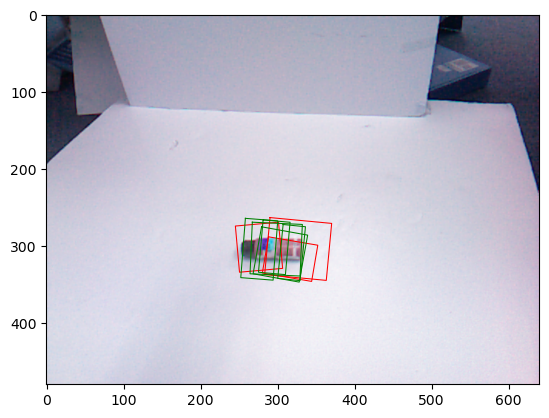

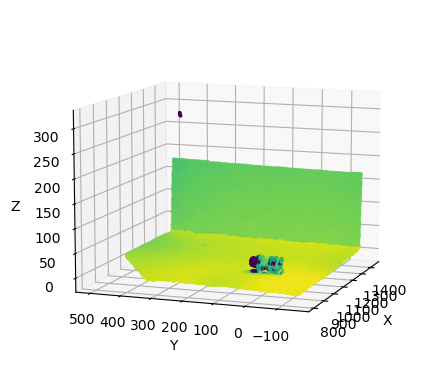

Mean Squared Error: 6.4392784e-06


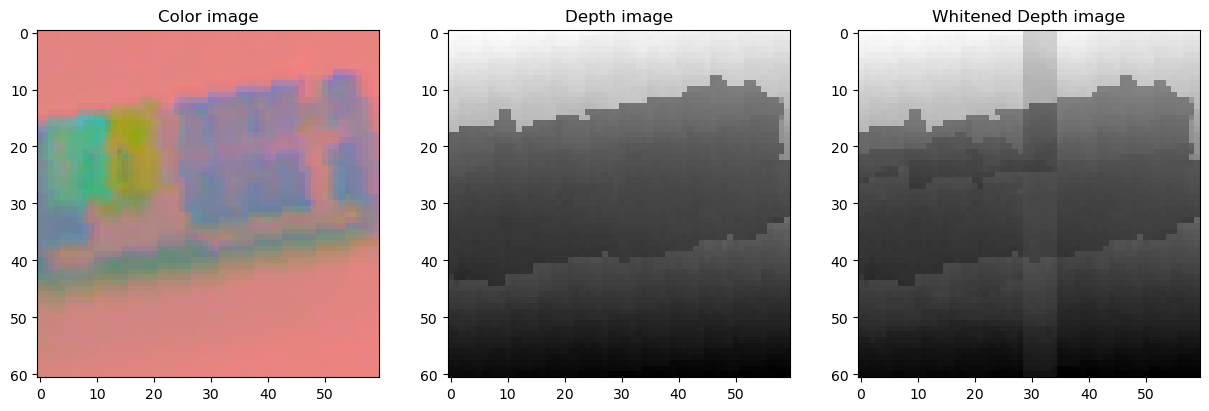

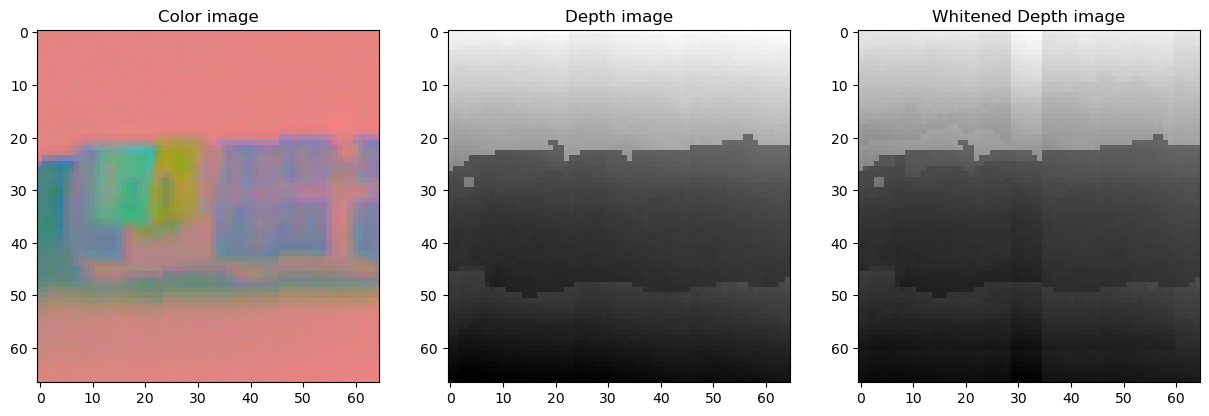

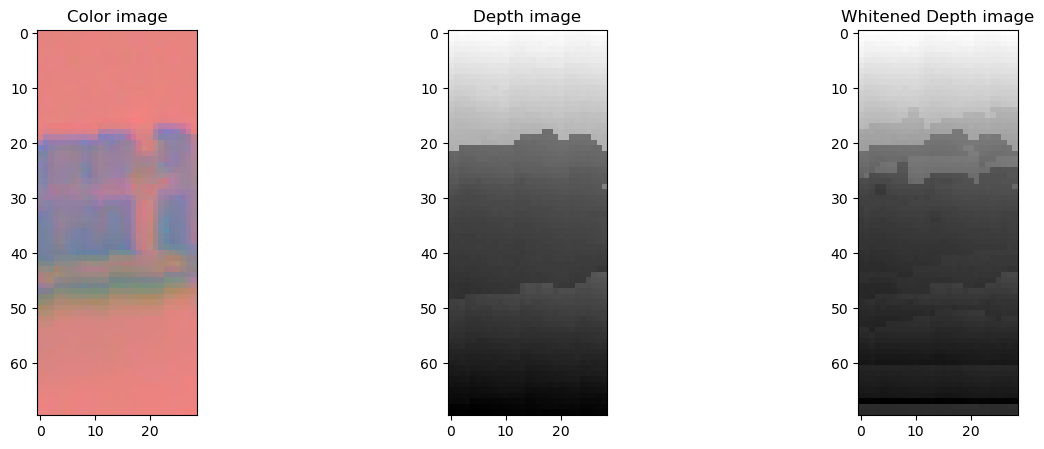

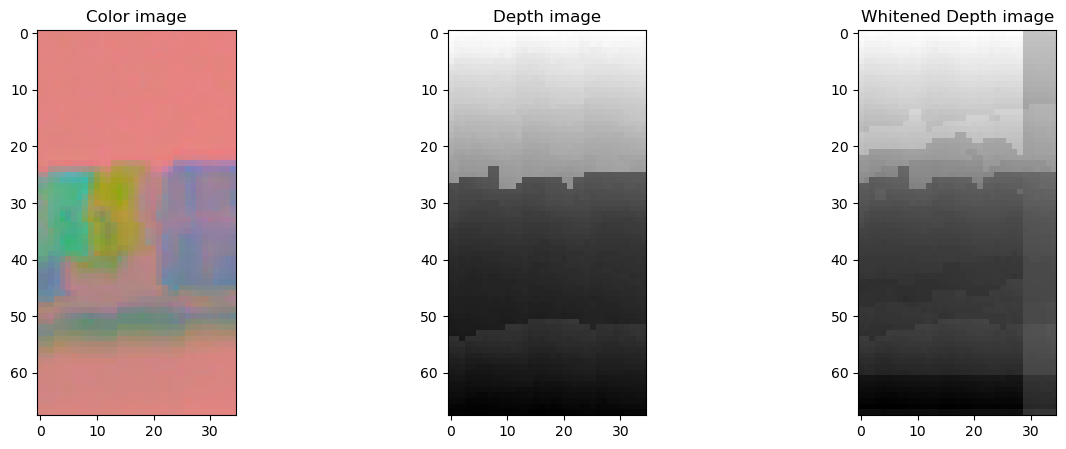

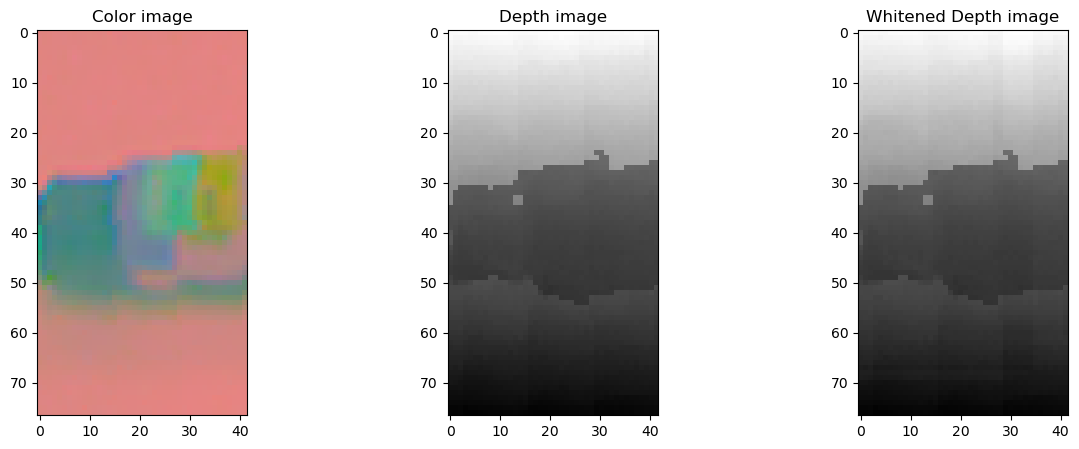

In [15]:
data_folder = os.path.join(os.path.dirname(os.getcwd()), "data_592", "robitics_grasp", "09")
print("Current Directory:", data_folder)

cneg_pattern = "*cneg.txt"
cpos_pattern = "*cpos.txt"
pcd_pattern = "pcd[0-9][0-9][0-9][0-9].txt"
png_pattern = "*.png"
tiff_pattern = "*.tiff"

cneg_files = sorted(glob.glob(os.path.join(data_folder, cneg_pattern)))
cpos_files = sorted(glob.glob(os.path.join(data_folder, cpos_pattern)))
pcd_files = sorted(glob.glob(os.path.join(data_folder, pcd_pattern)))
png_files = sorted(glob.glob(os.path.join(data_folder, png_pattern)))
tiff_files = sorted(glob.glob(os.path.join(data_folder, tiff_pattern)))

# Iterate over matching files and process them
for cneg_file, cpos_file, pcd_file, png_file, tiff_file in zip(cneg_files, cpos_files, pcd_files, png_files, tiff_files):
    positive_rectangles = read_coordinates(cpos_file)
    negative_rectangles = read_coordinates(cneg_file)
    png_image = cv2.imread(png_file)
    # tiff_image = imageio.imread(tiff_file)
    
    overlay_rectangles(png_image, positive_rectangles, negative_rectangles)
    depth_image = generate_depth_image(pcd_file).reshape(480,640,1)
    visualize_point_cloud(pcd_file)
    rgbd_image = np.concatenate([png_image, depth_image], axis=2)
    features = extract_features(rgbd_image, positive_rectangles)
    
    depth_features = [feature[1] for feature in features]
    depth_features, padding_infos = pad_depth_features(depth_features)
    
    whitened_depth_features = apply_pca_whitening(copy.deepcopy(depth_features))
    
    whitened_depth_features_original_shape = restore_original_shape(whitened_depth_features, padding_infos)
    
    mse = mean_squared_error(features[0][1], whitened_depth_features_original_shape[0])
    print("Mean Squared Error:", mse)

    
    for i, feature in enumerate(features):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].set_title('Color image')
        axes[0].imshow((feature[0]).astype(np.uint8))

        axes[1].set_title('Depth image')
        axes[1].imshow(feature[1], cmap="gray")

        axes[2].set_title('Whitened Depth image')
        axes[2].imshow(whitened_depth_features_original_shape[i], cmap="gray")

        plt.show()

    break